<a href="https://colab.research.google.com/github/tazar09/cars_dimensions/blob/main/comparison_05-feb2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [152]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# Scrapping the website

In [2]:
url = 'https://www.automobiledimension.com/compact-suv.php'
h3 = requests.get(url, verify = False)
html_content = h3.text

# Creating BeautifulSoup objects

In [3]:
soup = BeautifulSoup(html_content, 'html.parser')
main_table = soup.find('main')

In [4]:
temp_list = []
for i in main_table.find_all('div', class_ = 'unit'):
  link = str(i.a['href'])
  temp_list.append('https://www.automobiledimension.com' + link)
temp_list[0:3]

['https://www.automobiledimension.com/model/ford/puma',
 'https://www.automobiledimension.com/model/audi/q2',
 'https://www.automobiledimension.com/model/nissan/juke']

# Extract model description

In [5]:
def extract_main_text(text):
  search = text.find('div', class_ = 'interior-text')
  return search.text

In [6]:
def extract_boot_space(text):
  search = text.find_all('figcaption')[1]
  boot_space = search.text
  return boot_space

In [8]:
main_text_list = []
boot_space_list = []
for i in temp_list:
  content = requests.get(i, verify = False)
  content = BeautifulSoup(content.text, 'html.parser')
  main_text_list.append(extract_main_text(content))
  boot_space_list.append(extract_boot_space(content))

# Creating dataframe

In [ ]:
df = pd.DataFrame({'description': main_text_list, 'boot_space': boot_space_list})

In [335]:
def average(text):
  min, max = text.split('-')
  average = (int(max) + int(min))/2
  return average, int(min)

In [336]:
df['boot_space'] = df['boot_space'].str.replace('Boot space: ', '')
df['boot_space'] = df['boot_space'].str.replace(' liters.','')
df['boot_space'] = df['boot_space'].apply(lambda x: x.replace('* - ', '-') if len(x)>3 else x)

In [337]:
df['boot_mean'] = df['boot_space'].apply(lambda x: average(x)[0] if len(x) > 3 else int(x))
df['boot_normal'] = df['boot_space'].apply(lambda x: average(x)[1] if len(x) > 3 else int(x))


In [338]:
df.drop('boot_space', axis = 1, inplace = True)

In [339]:
df.head()

,description,boot_mean,boot_normal
0,"The Ford Puma has a length of 4207 mm, a heigh...",428.5,401
1,"The Audi Q2 has a length of 4208 mm, a height ...",405.0,405
2,"The Nissan Juke has a length of 4210 mm, a hei...",388.0,354
3,"The Opel Crossland has a length of 4212 mm, a ...",410.0,410
4,"The SsangYong Tivoli has a length of 4225 mm, ...",427.0,427


# Extract dimensions

In [340]:
def extract_dim(text):
  patterns = {
  'name': r'The\s+(.*?)\s+has',
  "length": r"length\s+of\s+(\d+)\s+mm",
  'measurement': r'measurement\s+of\s+(\d+)\s+millimeters',
  "height": r"height\s+of\s+(\d+)\s+mm",
  "width": r"width\s+of\s+(\d+)\s+mm",
  "ground_clearance": r"ground\s+clearance\s+of\s+(\d+)\s+cm",
  "category": r"category\s+of\s+(.*?)\."
  }

  car_info = {}

  for key, pattern in patterns.items():
    match = re.search(pattern, text)
    if match:
      car_info[key] = match.group(1) # Convert matched value to integer
    else:
      car_info[key] = None  # Set missing values to None

  return list(car_info.values()), list(car_info.keys())

In [341]:
columns = extract_dim(df['description'][0])[1]
for i in columns:
  df[i] = df['description'].apply(lambda x: extract_dim(x)[0][columns.index(i)])

In [ ]:
# reordering the columns

df = df[['name', 'category','length', 'height',
       'width','measurement', 'boot_normal', 'boot_mean', 'ground_clearance']]

df.head()

In [344]:
numeric_columns = df.columns[2:]
for i in numeric_columns:
  df[i] = df[i].apply(lambda x: np.NaN if (x == None) else int(x))

# Imputing missing values of measurement.

In [ ]:
df['mirrors'] = (pd.to_numeric(df['measurement'], errors='coerce') - df['width']).fillna(np.NaN)

In [347]:
df['mirror_rate'] = pd.to_numeric(df['mirrors'], errors = 'coerce') / df['width']
df['measurement']  = df['measurement'].replace('', np.NaN)
df['ground_clearance']  = df['ground_clearance'].replace('', np.NaN)
df['boot_mean']  = df['boot_mean'].replace('None', np.NaN)
df['boot_normal']  = df['boot_normal'].replace('None', np.NaN)

In [348]:
df['measurement'].fillna(round((df['width'] * (1+ df['mirror_rate'])), 0), inplace=True)

In [349]:
df.sort_values('boot_normal', ascending = False).head(10)

,name,category,length,height,width,measurement,boot_normal,boot_mean,ground_clearance,mirrors,mirror_rate
44,SsangYong Tivoli Grand,compact SUV,4480,1660,1810,NaN,574,574,17.0,NaN,NaN
39,SsangYong Korando,compact SUV,4450,1629,1870,NaN,551,551,17.0,NaN,NaN
51,Hyundai Tucson,compact SUV,4500,1650,1865,NaN,546,572,17.0,NaN,NaN
25,Skoda Karoq,compact SUV,4390,1603,1841,2025.0,521,521,17.0,184.0,0.099946
37,Peugeot 3008,mid-size SUV,4542,1641,1895,2108.0,520,520,NaN,213.0,0.112401
21,Seat Ateca,compact SUV,4381,1615,1841,2078.0,510,510,18.0,237.0,0.128734
50,BMW X1,compact SUV,4500,1642,1845,2104.0,490,515,20.0,259.0,0.140379
22,CUPRA Ateca,compact SUV,4386,1613,1841,2078.0,485,485,17.0,237.0,0.128734
34,Nissan Qashqai,compact SUV,4425,1635,1838,2084.0,480,480,18.0,246.0,0.133841
20,Land-Rover Range Rover Evoque,compact SUV,4371,1649,1904,2100.0,472,472,21.0,196.0,0.102941


In [350]:
(2108 - 1895)/1895

0.11240105540897098

In [351]:
round((1895 * (1+0.112401)), 0)

2108.0

<Axes: ylabel='Frequency'>

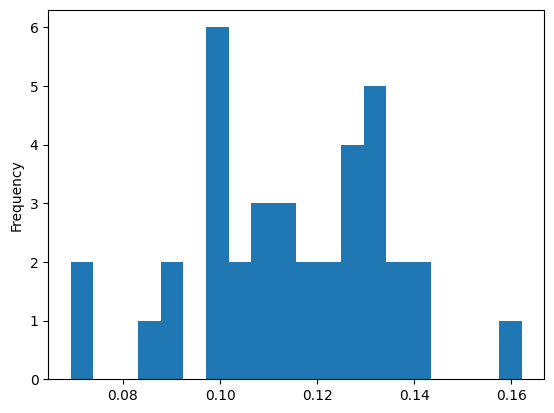

In [352]:
df['mirror_rate'].plot(kind = 'hist', bins = 20)